In [1]:
# for the hamiltonian and diagonalization
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from tqdm.notebook import tqdm as tq
import itertools
from functools import reduce

# for the dataset
import torch
from torch_geometric.data import Data

# other useful things
import os, sys, psutil
from IPython.display import clear_output
import warnings; warnings.simplefilter('ignore')

# Helper functions

In [2]:
def mapp(func, *iterables, cb=None, **kwargs):
    """map function that uses tq for progress bar"""
    for i in tq(range(len(iterables[0]))):
        res = func(*[iterable[i] for iterable in iterables], **kwargs)
        if cb is not None:
            cb(res)
        yield res

def imshow(a, figsize=(8,6), cmap='seismic', **pltargs):
    """Uses magic to create pretty images from arrays."""

    if sp.issparse(a):
        a = a.todense()
    else:
        a = np.array(a, copy=False)
    if np.prod(a.shape) == np.max(a.shape):
        a = a.flatten()
    fig = plt.figure(figsize=figsize)
    cmap = plt.get_cmap(cmap)
    if 'vmin' not in pltargs and 'vmax' not in pltargs:
        vmax = np.max(np.abs(a))
        vmin = -vmax
    plt.imshow(a, cmap=cmap, vmin=vmin, vmax=vmax, **pltargs)
    plt.colorbar()

def hist(data, bins=None, xlabel="", title="", density=False):
    def bins_sqrt(data):
        return int(np.ceil(np.sqrt(len(data))))

    plt.figure(figsize=(10,5))

    # bins
    if not bins:
        bins = bins_sqrt(data)
    n, bins, _ = plt.hist(data, bins=bins, density=density)

    # visuals
    plt.title(title)
    plt.ylabel("Density" if density else "Frequency")
    plt.xlabel(xlabel)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    return n, bins

def scatter1d(data, xticks=None, alpha=.5, s=500, marker="|", xlim=None, title="", **pltargs):
    """Create only one axis on which to plot the data."""

    fig = plt.figure(figsize=(10,1))
    ax = fig.gca()
    size = np.array(data, copy=False).flatten().shape
    plt.scatter(data, np.zeros(*size), alpha=alpha, marker=marker, s=s, **pltargs)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    if xticks:
        ax.set_xticks(xticks)
    if title:
        ax.set_title(title)
    if xlim is not None:
        ax.set_xlim(xlim)
    fig.tight_layout()
    plt.show()

def duh(n, precision=2):
    """ Takes a number of bytes and returns a human-readable string with the
    size in bytes, kilobytes, megabytes, or gigabytes.

    Parameters
        n (int): The number of bytes
        precision (int): The number of decimals to use
    """
    for unit in ['B','KB','MB','GB','TB','PB','EB','ZB']:
        if n < 1024.0:
            break
        n /= 1024.0
    decimals = precision - int(n > 99) - int(n > 9) - int(n > 0)
    if decimals < 0 or unit == 'B':
        decimals = 0
    return f"{n:.{decimals}f} {unit}"

def ising_model_graph(graph, J=(-1,1), h=(-1,1), g=(-1,1)):
    """ Takes a graph and generates a Hamiltonian string for it that is compatible with `parse_hamiltonian`. """
    if not isinstance(graph, nk.graph.Graph):
        raise ValueError(f"graph must be a nk.graph.Graph, but is {type(graph)}")
    
    # get the number of qubits
    n_qubits = graph.n_nodes
    # get the edges
    edges = graph.edges()
    # get the coupling matrix
    J = np.array(J)
    if J.shape == ():
        # triangular matrix with all couplings set to J
        J = np.triu(np.ones((n_qubits, n_qubits)), k=1) * J
    elif J.shape == (2,):
        # triangular matrix with all couplings set to a random value in this range
        J = np.triu(np.random.uniform(J[0], J[1], (n_qubits, n_qubits)), k=1)
    elif J.shape == (n_qubits, n_qubits):
        # use the given matrix
        pass
    else:
        raise ValueError(f"J must be a scalar, 2-element vector, or matrix of shape {(n_qubits, n_qubits)}, but is {J.shape}")
    
    # get the longitudinal fields
    if h is not None:
        h = np.array(h)
        if h.shape == ():
            h = np.ones(n_qubits) * h
        elif h.shape == (2,):
            h = np.random.uniform(h[0], h[1], n_qubits)
        elif h.shape == (n_qubits,):
            pass
        else:
            raise ValueError(f"h must be a scalar, 2-element vector, or vector of shape {(n_qubits,)}, but is {h.shape}")
        
    # get the transverse fields
    if g is not None:
        g = np.array(g)
        if g.shape == ():
            g = np.ones(n_qubits) * g
        elif g.shape == (2,):
            g = np.random.uniform(g[0], g[1], n_qubits)
        elif g.shape == (n_qubits,):
            pass
        else:
            raise ValueError(f"g must be a scalar, 2-element vector, or vector of shape {(n_qubits,)}, but is {g.shape}")
        
    # generate the Hamiltonian
    H_str = ''
    # pairwise interactions
    for i, j in edges:
        assert i < j, f"edges must be sorted, but ({i}, {j}) is not"
        if J[i,j] != 0:
            H_str += str(J[i,j]) + '*' + 'I'*i + 'Z' + 'I'*(j-i-1) + 'Z' + 'I'*(n_qubits-j-1) + ' + '
    # local longitudinal fields
    if np.any(h):
        H_str += ' + '.join([str(h[i]) + '*' + 'I'*i + 'Z' + 'I'*(n_qubits-i-1) for i in range(n_qubits) if h[i] != 0]) + ' + '
    # local transverse fields
    if np.any(g):
        H_str += ' + '.join([str(g[i]) + '*' + 'I'*i + 'X' + 'I'*(n_qubits-i-1) for i in range(n_qubits) if g[i] != 0]) + ' + '

    # remove trailing ' + '
    H_str = H_str[:-3]

    return H_str

matmap_np, matmap_sp = None, None  # global variables for the matrix map, so we don't have to recompute it every time and can use it outside of the function

def parse_hamiltonian(hamiltonian, sparse=False, scaling=1, buffer=None, max_buffer_n=0, dtype=float): # I'd usually default to complex, but because we're only dealing with Ising models here, float is more handy
    """Parse a string representation of a Hamiltonian into a matrix representation. The result is guaranteed to be Hermitian.

    Parameters:
        hamiltonian (str): The Hamiltonian to parse.
        sparse (bool): Whether to use sparse matrices (csr_matrix) or dense matrices (numpy.array).
        scaling (float): A constant factor to scale the Hamiltonian by.
        buffer (dict): A dictionary to store calculated chunks in. If `None`, it defaults to the global `matmap_np` (or `matmap_sp` if `sparse == True`). Give `buffer={}` and leave `max_buffer_n == 0` (default) to disable the buffer.
        max_buffer_n (int): The maximum length (number of qubits) for new chunks to store in the buffer (default: 0). If `0`, no new chunks will be stored in the buffer.

    Returns:
        numpy.ndarray | scipy.sparse.csr_matrix: The matrix representation of the Hamiltonian.

    Example:
    >>> parse_hamiltonian('0.5*(XX + YY + ZZ + II)') # SWAP
    array([[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
           [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
           [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
           [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]])
    >>> parse_hamiltonian('-(XX + YY + .5*ZZ) + 1.5')
    array([[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
           [ 0.+0.j  2.+0.j -2.+0.j  0.+0.j]
           [ 0.+0.j -2.+0.j  2.+0.j  0.+0.j]
           [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]])
    >>> parse_hamiltonian('0.5*(II + ZI - ZX + IX)') # CNOT

    """
    kron = sp.kron if sparse else np.kron

    # Initialize the matrix map
    global matmap_np, matmap_sp
    if matmap_np is None or matmap_sp is None or matmap_np["I"].dtype != dtype:
        # numpy versions
        matmap_np = {
            "H": np.array([[1, 1], [1, -1]], dtype=dtype) / np.sqrt(2),
            "X": np.array([[0, 1], [1, 0]], dtype=dtype),
            "Z": np.array([[1, 0], [0, -1]], dtype=dtype),
            "I": np.array([[1, 0], [0, 1]], dtype=dtype),
        }
        # composites
        matmap_np.update({
            "ZZ": np.kron(matmap_np['Z'], matmap_np['Z']),
            "IX": np.kron(matmap_np['I'], matmap_np['X']),
            "XI": np.kron(matmap_np['X'], matmap_np['I']),
            "YY": np.array([[ 0,  0,  0, -1],  # to avoid complex numbers
                            [ 0,  0,  1,  0],
                            [ 0,  1,  0,  0],
                            [-1,  0,  0,  0]], dtype=dtype)
        })
        for i in range(2, 11):
            matmap_np["I"*i] = np.eye(2**i, dtype=dtype)
        # add 'Y' only if dtype supports imaginary numbers
        if np.issubdtype(dtype, np.complexfloating):
            matmap_np["Y"] = np.array([[0, -1j], [1j, 0]], dtype=dtype)

        # sparse versions
        matmap_sp = {k: sp.csr_array(v) for k, v in matmap_np.items()}
    
    if not np.issubdtype(dtype, np.complexfloating) and "Y" in hamiltonian:
        raise ValueError(f"The Pauli matrix Y is not supported for dtype {dtype.__name__}.")

    matmap = matmap_sp if sparse else matmap_np

    # only use buffer if pre-computed chunks are available or if new chunks are allowed to be stored
    use_buffer = buffer is None or len(buffer) > 0 or max_buffer_n > 0
    if use_buffer and buffer is None:
        buffer = matmap

    def calculate_chunk_matrix(chunk, sparse=False, scaling=1):
        # if scaling != 1:  # only relevant for int dtype
            # scaling = np.array(scaling, dtype=dtype)
        if use_buffer:
            if chunk in buffer:
                return buffer[chunk] if scaling == 1 else scaling * buffer[chunk]
            if len(chunk) == 1:
                return matmap[chunk[0]] if scaling == 1 else scaling * matmap[chunk[0]]
            # Check if a part of the chunk has already been calculated
            for i in range(len(chunk)-1, 1, -1):
                for j in range(len(chunk)-i+1):
                    subchunk = chunk[j:j+i]
                    if subchunk in buffer:
                        # If so, calculate the rest of the chunk recursively
                        parts = [chunk[:j], subchunk, chunk[j+i:]]
                        # remove empty chunks
                        parts = [c for c in parts if c != ""]
                        # See where to apply the scaling
                        shortest = min(parts, key=len)
                        # Calculate each part recursively
                        for i, c in enumerate(parts):
                            if c == subchunk:
                                if c == shortest:
                                    parts[i] = scaling * buffer[c]
                                    shortest = ""
                                else:
                                    parts[i] = buffer[c]
                            else:
                                if c == shortest:
                                    parts[i] = calculate_chunk_matrix(c, sparse=sparse, scaling=scaling)
                                    shortest = ""
                                else:
                                    parts[i] = calculate_chunk_matrix(c, sparse=sparse, scaling=1)
                        return reduce(kron, parts)

        # Calculate the chunk matrix gate by gate
        if use_buffer and len(chunk) <= max_buffer_n:
            gates = [matmap[gate] for gate in chunk]
            chunk_matrix = reduce(kron, gates)
            buffer[chunk] = chunk_matrix
            if scaling != 1:
                chunk_matrix = scaling * chunk_matrix
        else:
            gates = [scaling * matmap[chunk[0]]] + [matmap[gate] for gate in chunk[1:]]
            chunk_matrix = reduce(kron, gates)

        return chunk_matrix

    # Remove whitespace
    hamiltonian = hamiltonian.replace(" ", "")
    # replace - with +-, except before e
    hamiltonian = hamiltonian \
                    .replace("-", "+-") \
                    .replace("e+-", "e-") \
                    .replace("(+-", "(-")

    # print("parse_hamiltonian: Pre-processed Hamiltonian:", hamiltonian)

    # Find parts in parentheses
    part = ""
    parts = []
    depth = 0
    current_part_weight = ""
    for i, c in enumerate(hamiltonian):
        if c == "(":
            if depth == 0:
                # for top-level parts search backwards for the weight
                weight = ""
                for j in range(i-1, -1, -1):
                    if hamiltonian[j] in ["("]:
                        break
                    weight += hamiltonian[j]
                    if hamiltonian[j] in ["+", "-"]:
                        break
                weight = weight[::-1]
                if weight != "":
                    current_part_weight = weight
            depth += 1
        elif c == ")":
            depth -= 1
            if depth == 0:
                part += c
                parts.append((current_part_weight, part))
                part = ""
                current_part_weight = ""
        if depth > 0: 
            part += c

    # print("Parts found:", parts)

    # Replace parts in parentheses with a placeholder
    for i, (weight, part) in enumerate(parts):
        hamiltonian = hamiltonian.replace(weight+part, f"+part{i}", 1)
        # remove * at the end of the weight
        if weight != "" and weight[-1] == "*":
            weight = weight[:-1]
        if weight in ["", "+", "-"]:
            weight += "1"
        # Calculate the part recursively
        part = part[1:-1] # remove parentheses
        parts[i] = parse_hamiltonian(part, sparse=sparse, scaling=float(weight), buffer=buffer, max_buffer_n=max_buffer_n, dtype=dtype)

    # print("Parts replaced:", parts)

    # Parse the rest of the Hamiltonian
    chunks = hamiltonian.split("+")
    # Remove empty chunks
    chunks = [c for c in chunks if c != ""]
    # If parts are present, use them to determine the number of qubits
    if parts:
        n = int(np.log2(parts[0].shape[0]))
    else: # Use chunks to determine the number of qubits
        n = 0
        for c in chunks:
            if c[0] in ["-", "+"]:
                c = c[1:]
            if "*" in c:
                c = c.split("*")[1]
            if c.startswith("part"):
                continue
            try:
                float(c)
                continue
            except ValueError:
                n = len(c)
                break
        if n == 0:
            print("Warning: Hamiltonian is a scalar!")

    if not sparse and n > 10:
        # check if we would blow up the memory
        mem_required = 2**(2*n) * np.array(1, dtype=dtype).nbytes
        mem_available = psutil.virtual_memory().available
        if mem_required > mem_available:
            raise MemoryError(f"This would blow up you memory ({duh(mem_required)} required)! Try using `sparse=True`.")

    if sparse:
        H = sp.csr_array((2**n, 2**n), dtype=dtype)
    else:
        if n > 10:
            print(f"Warning: Using a dense matrix for a {n}-qubit Hamiltonian is not recommended. Use sparse=True.")
        H = np.zeros((2**n, 2**n), dtype=dtype)

    for chunk in chunks:
        # print("Processing chunk:", chunk)
        chunk_matrix = None
        if chunk == "":
            continue
        # Parse the weight of the chunk
        
        if chunk.startswith("part"):
            weight = 1  # parts are already scaled
            chunk_matrix = parts[int(chunk.split("part")[1])]
        elif "*" in chunk:
            weight = float(chunk.split("*")[0])
            chunk = chunk.split("*")[1]
        elif len(chunk) == n+1 and chunk[0] in ["-", "+"] and n >= 1 and chunk[1] in matmap:
            weight = float(chunk[0] + "1")
            chunk = chunk[1:]
        elif (chunk[0] in ["-", "+", "."] or chunk[0].isdigit()) and all([c not in matmap for c in chunk[1:]]):
            if len(chunk) == 1 and chunk[0] in ["-", "."]:
                chunk = 0
            weight = complex(chunk)
            if np.iscomplex(weight):
                raise ValueError("Complex scalars would make the Hamiltonian non-Hermitian!")
            weight = weight.real
            # weight = np.array(weight, dtype=dtype)  # only relevant for int dtype
            chunk_matrix = np.eye(2**n, dtype=dtype)
        elif len(chunk) != n:
            raise ValueError(f"Gate count must be {n} but was {len(chunk)} for chunk \"{chunk}\"")
        else:
            weight = 1

        if chunk_matrix is None:
            chunk_matrix = calculate_chunk_matrix(chunk, sparse=sparse, scaling = scaling * weight)
        elif scaling * weight != 1:
            chunk_matrix = scaling * weight * chunk_matrix

        # Add the chunk to the Hamiltonian
        # print("Adding chunk", weight, chunk, "for hamiltonian", scaling, hamiltonian)
        # print(type(H), H.dtype, type(chunk_matrix), chunk_matrix.dtype)
        if len(chunks) == 1:
            H = chunk_matrix
        else:
            H += chunk_matrix

    if sparse:
        assert np.allclose(H.data, H.conj().T.data), f"The given Hamiltonian {hamiltonian} is not Hermitian: {H.data}"
    else:
        assert np.allclose(H, H.conj().T), f"The given Hamiltonian {hamiltonian} is not Hermitian: {H}"

    return H

def calculate_rdms(state):
    """ Calculate reduced density matrix for each node and each edge in the fully connected graph. """

    n = int(np.log2(state.shape[0]))
    # calculate reduced density matrix for each node
    node_rdms = []
    for i in range(n):
        rdm_i = partial_trace(state, i)
        # reshape to a matrix
        node_rdms.append(np.array(rdm_i))
    # calculate reduced density matrix for each edge
    edge_rdms = []
    for i,j in itertools.combinations(range(n), 2):
        rdm_ij = partial_trace(state, [i,j])
        edge_rdms.append(np.array(rdm_ij))
    return np.array(node_rdms), np.array(edge_rdms)

def get_n_qubits(hamiltonian):
    if isinstance(hamiltonian, str):
        N = parse_hamiltonian(hamiltonian, sparse=True).shape[0]
    elif isinstance(hamiltonian, nk.operator.DiscreteOperator):
        N = hamiltonian.hilbert.size
    else:
        N = hamiltonian.shape[0]
    return int(np.log2(N))

# from https://qiskit.org/documentation/stable/0.35/stubs/qiskit.quantum_info.partial_trace.html
def partial_trace(rho, retain_qubits):
    """Trace out all qubits not specified in `retain_qubits`."""
    rho = np.array(rho)
    n = int(np.log2(rho.shape[0])) # number of qubits

    # pre-process retain_qubits
    if isinstance(retain_qubits, int):
        retain_qubits = [retain_qubits]
    dim_r = 2**len(retain_qubits)

    # get qubits to trace out
    trace_out = np.array(sorted(set(range(n)) - set(retain_qubits)))
    # ignore all qubits >= n
    trace_out = trace_out[trace_out < n]

    # if rho is a state vector
    if len(rho.shape) == 1:
        st  = rho.reshape([2]*n)
        rho = np.tensordot(st, st.conj(), axes=(trace_out,trace_out))
    # if trace out all qubits, just return the normal trace
    elif len(trace_out) == n:
        return np.trace(rho).reshape(1,1) # dim_r is not necessarily 1 here (if some in `retain_qubits` are >= n)
    else:
        assert rho.shape[0] == rho.shape[1], f"Can't trace a non-square matrix {rho.shape}"

        rho = rho.reshape([2]*(2*n))
        for qubit in trace_out:
            rho = np.trace(rho, axis1=qubit, axis2=qubit+n)
            n -= 1         # one qubit less
            trace_out -= 1 # rename the axes (only "higher" ones are left)

    return rho.reshape(dim_r, dim_r)

def edges_from_graph(graph, undirected=False):
    edges = graph.edges()
    edges = np.array(edges).T
    if undirected:
        edges = np.concatenate([edges, edges[:,::-1]], axis=0)
    edges = np.unique(edges, axis=0)  # sorts the edges
    return edges[0], edges[1]

# from https://docs.pennylane.ai/en/stable/code/api/pennylane.pauli_decompose.html
def pauli_decompose(H):
    r"""Decomposes a Hermitian matrix into a linear combination of Pauli operators.

    Args:
        H (array[complex]): a Hermitian matrix of dimension :math:`2^n\times 2^n`.

    Returns:
        tuple[list[float], list[str]]: the coefficients and the Pauli operator strings

    **Example:**

    We can use this function to compute the Pauli operator decomposition of an arbitrary Hermitian
    matrix:

    >>> H = np.array(
    ... [[-2, -2+1j, -2, -2], [-2-1j,  0,  0, -1], [-2,  0, -2, -1], [-2, -1, -1,  0]])
    >>> pauli_decompose(H)
    ([-1.0, -1.5, -0.5, -1.0, -1.5, -1.0, -0.5,  1.0, -0.5, -0.5],
     ['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XZ', 'YY', 'ZX', 'ZY'])
    """
    n = int(np.log2(len(H)))
    N = 2**n

    if H.shape != (N, N):
        raise ValueError("The matrix should have shape (2**n, 2**n), for any qubit number n>=1")

    if not np.allclose(H, H.conj().T):
        raise ValueError("The matrix is not Hermitian")

    obs_lst = []
    coeffs = []

    for term in itertools.product(['I', 'X', 'Y', 'Z'], repeat=n):
        term = "".join(term)
        basis_matrix = reduce(np.kron, [matmap_np[i] for i in term])
        coeff = np.trace(basis_matrix @ H) / N  # project H onto the basis matrix
        coeff = np.real_if_close(coeff).item()

        if not np.allclose(coeff, 0):
            coeffs.append(coeff)
            obs_lst.append(term)

    return coeffs, obs_lst

# Generate random ising hamiltonians

## nk.operator.Ising

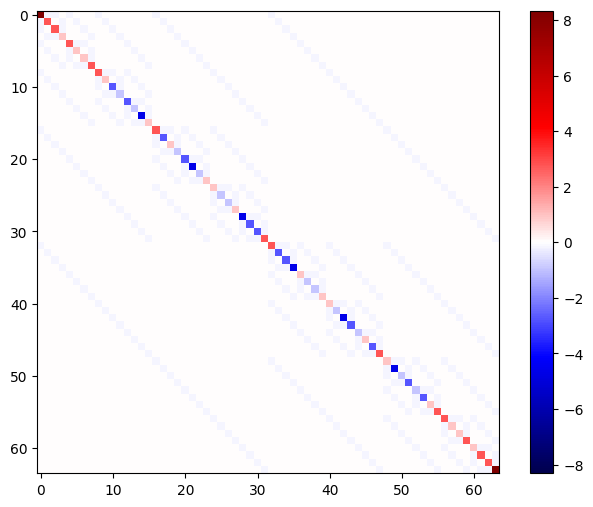

In [3]:
# Generate random ising hamiltonians
def random_ising_nk(N: int, graph: nk.graph.Grid):
    J = np.random.uniform(-1, 1, size=N) # Coupling constant
    g = np.random.uniform(-1, 1, size=N) # Transverse field
    n = graph.n_nodes
    edges = edges_from_graph(graph)
    hilbert = nk.hilbert.Spin(s=0.5, N=n)
    h = np.zeros(n)
    n_ones = np.ones(n)

    hamiltonians = []
    for i in range(N):
        ising = nk.operator.Ising(
            hilbert=hilbert,
            graph=graph,
            J=J[i], h=g[i]
        )

        # Convert hyperparameters to the right format
        J_i = np.zeros((n, n))
        J_i[edges] = J[i]
        # convert to triu list
        J_i = J_i[np.triu_indices(n, k=1)]
    
        hamiltonians.append((ising, graph.extent, {"J": J_i, "h": h, "g": g[i]*n_ones}))
    return hamiltonians

# Generate a random ising hamiltonian
imshow(random_ising_nk(1, graph=nk.graph.Grid((2,3), pbc=True))[0][0].to_dense())

## ising_model_graph

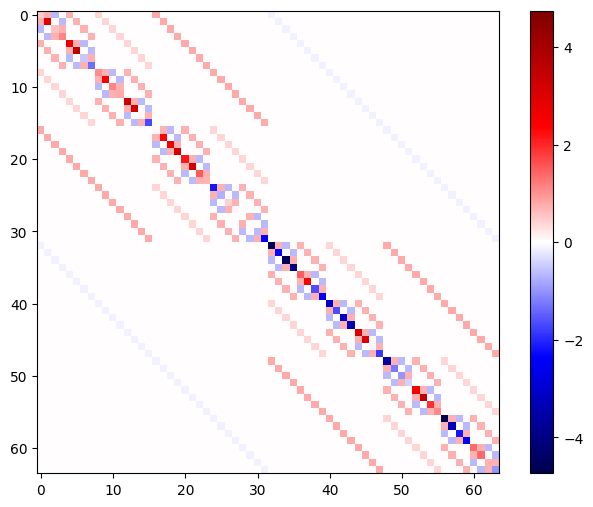

In [4]:
# Use the ising_model_graph function to generate more general ising models
def random_ising_own(N: int, graph: nk.graph.Grid):
    """ Generates N random ising models on the given graph. """
    n = graph.n_nodes
    J = np.random.uniform(-1, 1, size=(N, n, n))
    # # make sure each J is symmetric
    # for i in range(N):
    #     J[i] = (J[i] + J[i].T)/2
    #     # make sure the diagonal is zero
    #     J[i] -= np.diag(np.diag(J[i]))
    h = np.random.uniform(-1, 1, size=(N, n))
    g = np.random.uniform(-1, 1, size=(N, n))

    # get the edges for the coupling matrix
    edges = edges_from_graph(graph)

    hamiltonians = []
    for i in range(N):
        H_ising_str = ising_model_graph(graph, J[i], h[i], g[i])

        # create the coupling matrix
        J_i = np.zeros((n, n))
        J_i[edges] = J[i][edges]
        # convert to triu list
        J_i = J_i[np.triu_indices(n, k=1)]
    
        hamiltonians.append((H_ising_str, graph.extent, {"J": J_i, "h": h[i], "g": g[i]}))

    return hamiltonians

# This creates a hamiltonian like netket does, but using the ising_model function
def random_ising_own_like_nk(N: int, graph: nk.graph.Grid):
    """ The main differences with generate_random_ising is (1) the coupling and field strengths are everywhere the same and (2) there is no longitudinal local field."""
    J = np.random.uniform(-1, 1, size=N)
    g = np.random.uniform(-1, 1, size=N)
    n = graph.n_nodes
    h = np.zeros(n)
    ones = np.ones(n)

    # get the edges for the coupling matrix
    edges = edges_from_graph(graph)

    hamiltonians = []
    for i in range(N):
        H_ising_str = ising_model_graph(graph, J[i], 0, g[i])

        # create the coupling and field matrices
        J_i = np.zeros((n,n))
        J_i[edges] = J[i]
        # convert to triu list
        J_i = J_i[np.triu_indices(n, k=1)]

        hamiltonians.append((H_ising_str, graph.extent, {"J": J_i, "h": h, "g": g[i]*ones}))

    return hamiltonians

# show a random hamiltonian
imshow(parse_hamiltonian(random_ising_own(N=1, graph=nk.graph.Grid((2,3), pbc=True))[0][0]))

## Check equivalence
Check if the dense matrices produced by the netket library and the ones produced by the ising_model_graph function are equivalent.

In [5]:
graph = nk.graph.Grid((2,4), pbc=True)  # for dense
J = np.random.uniform(-1, 1)
h = np.random.uniform(-1, 1)

# check if the Hilbert space dimension is too large (happens too easily)
H_dim = 2**(graph.n_nodes)
mem_required = H_dim**2 *8*2  # 8 bytes per float, 2 matrices
if mem_required > psutil.virtual_memory().available:
    raise ValueError(f"Warning: Large Hilbert space dimension {H_dim}! This would blow up your memory ({duh(mem_required)} required)!")
elif H_dim > 2**12:
    print(f"Warning: Large Hilbert space dimension {H_dim}! This may take a while ({duh(mem_required)} RAM required)!")

# netket version of the Ising model
ising_nk = nk.operator.Ising(
    hilbert=nk.hilbert.Spin(s=0.5, N=graph.n_nodes),
    graph=graph,
    J=J, h=h
).to_dense()
# corresponds to the following special case
H_str = ising_model_graph(graph, J, 0, -h)
ising_own = parse_hamiltonian(H_str)

np.allclose(ising_nk, ising_own)

True

# Calculate ground state energies

## Exact diagonalization

In [6]:
def diagonalize(hamiltonian, *args):
    if isinstance(hamiltonian, str):
        H = parse_hamiltonian(hamiltonian, sparse=True)
    elif isinstance(hamiltonian, nk.operator.DiscreteOperator):
        H = hamiltonian.to_sparse()
    else:
        H = hamiltonian

    evals, evecs = sp.linalg.eigsh(H, k=1, which='SA')
    ground_state_energy = evals[0]
    ground_state = evecs[:,0]
    return ground_state_energy, ground_state

### **The actual generation is happening here!!!**

In [7]:
def generate_dataset(hamiltonians, data_path=None, progress=True, extend_if_exists=True):
    """Generate the data set using exact diagonalization. This function does three things:
    1. Diagonalize the given Hamiltonians using exact diagonalization.
    2. Calculate the reduced density matrix of the ground state for each node and each edge in the fully connect graph.
    3. Save the data set to a file specified by data_path (optional).

    If `extend_if_exists` is `True` and `data_path` is passed, the existing data set is extended by the new data and 
    the combined data set is saved to `data_path` and returned.

    Parameters
        hamiltonians (List[tuple]): list of 2-tuples, with Hamiltonians to be diagonalized and their hyperparameters
        data_path (str): path to save the data set

    Returns
        data (Dataset)
    """
    if data_path is not None:
        # add extension if not present
        if not data_path.endswith('.pt'):
            data_path += '.pt'
        if os.path.exists(data_path):
            if not extend_if_exists:
                raise ValueError(f"Data set already exists at {data_path}!")
            # load existing data
            data_old = torch.load(data_path)
        else:
            os.makedirs(os.path.dirname(data_path), exist_ok=True)
            data_old = None
    if len(hamiltonians) == 0:
        if data_path is not None and data_old is not None:
            return data_old
        else:
            raise ValueError('No Hamiltonians given and no already generated data set found.')

    data = []
    for i in tq(range(len(hamiltonians)), desc='Generating data set', disable=not progress):
        # get Hamiltonian
        H, grid_extent, hyperparameters = hamiltonians[i]
        # get ground state energy and state
        ground_state_energy, ground_state = diagonalize(H)
        # calculate reduced density matrix for each node and each edge
        node_rdms, edge_rdms = calculate_rdms(ground_state)

        # Convert to PyTorch tensors
        ground_state_energy = torch.tensor(ground_state_energy, dtype=torch.float32)
        # ground_state = torch.tensor(ground_state, dtype=torch.float32)  # not needed and too large

        # Hamiltonian parameters
        J = torch.tensor(hyperparameters['J'], dtype=torch.float32)
        h = torch.tensor(hyperparameters['h'], dtype=torch.float32)
        g = torch.tensor(hyperparameters['g'], dtype=torch.float32)
        local_field_strength = torch.stack([h, g], dim=1)

        # Create a PyTorch Geometric Data object
        n = len(node_rdms)
        edge_index = torch.triu_indices(n, n, offset=1)
        datum = Data(x_nodes=local_field_strength, x_edges=J, edge_index=edge_index, y_node_rdms=node_rdms, y_edge_rdms=edge_rdms, y_energy=ground_state_energy, grid_extent=grid_extent)

        data.append(datum)

    if data_path is not None:
        if data_old is not None:
            # merge old and new data
            data = data_old + data
        # save data
        torch.save(data, data_path)

    return data

Generate 100 graphs of shape (12,)
Generate 100 graphs of shape (2, 6)
Generate 100 graphs of shape (3, 4)
Generate 100 graphs of shape (11,)
Generate 100 graphs of shape (10,)
Generate 100 graphs of shape (2, 5)
Generate 100 graphs of shape (9,)
Generate 100 graphs of shape (8,)
Generate 100 graphs of shape (2, 4)
Generate 100 graphs of shape (7,)
Generate 100 graphs of shape (6,)
Generate 100 graphs of shape (2, 3)
Generate 100 graphs of shape (5,)
Generate 100 graphs of shape (4,)
Generate 100 graphs of shape (3,)
Generate 100 graphs of shape (2,)


Generating data set:   0%|          | 0/1600 [00:00<?, ?it/s]

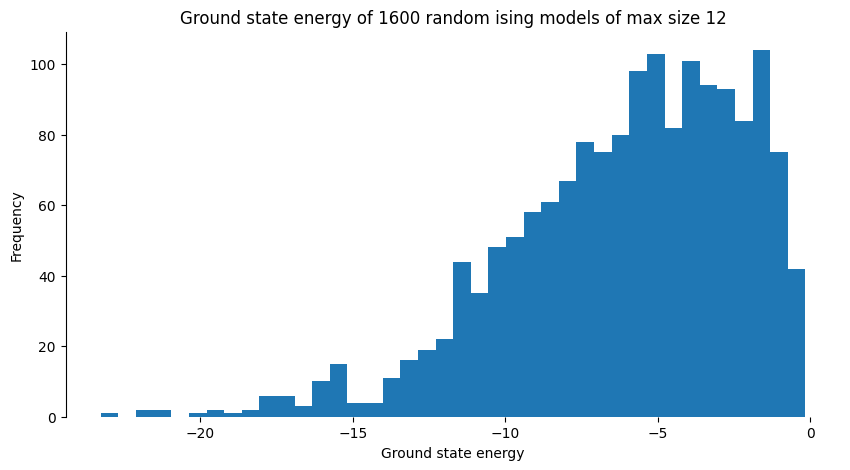

In [13]:
clear_output()
# Complex dataset generate
N = 100
max_qubits = 12
circular = True
# Generate lattice dimensions (use product to include permutations, e.g. (2,3) and (3,2) )
dims_1d = [n for n in itertools.combinations(range(2,25), r=1)]
dims_2d = [n for n in itertools.combinations(range(2,13), r=2)]
dims_3d = [n for n in itertools.combinations(range(2,7), r=3)]
dims = dims_1d + dims_2d + dims_3d
# filter with np.prod(n) <= max_qubits
dims = [n for n in dims if np.prod(n) <= max_qubits]
# sort by number of qubits, slowest first
dims = sorted(dims, key=lambda x: np.prod(x), reverse=True)

# generate abstract hamiltonians
hamiltonians = []
for n in dims:
    print(f"Generate {N} graphs of shape {n}")
    graph = nk.graph.Grid(n, pbc=circular)
    hamiltonians += random_ising_nk(N, graph)
    # hamiltonians += random_ising_own(N, graph)

N_total = N * len(dims)
data = generate_dataset(hamiltonians, data_path=f'data/nk_{N_total}_{max_qubits}_{circular}', extend_if_exists=False)

# Plot
_ = hist([d['y_energy'] for d in data], xlabel="Ground state energy", title=f"Ground state energy of {len(data)} random ising models of max size {max_qubits}")

Generating data set:   0%|          | 0/100 [00:00<?, ?it/s]

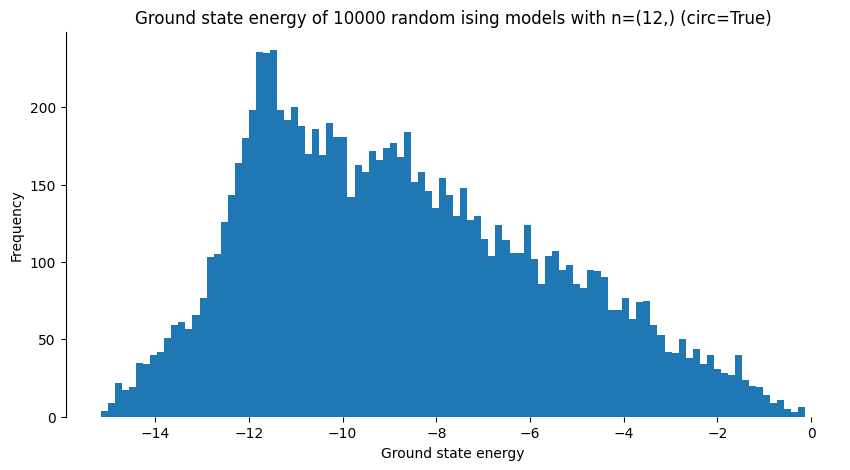

In [9]:
clear_output()
n = (12,) # System size
          # Timing for exact diagonalization (on M1 chip)
          # (8,) => 34000 / min, (12,) => 1500 / min, (16,) => 100 / min, (20,) => 4 / min
          # (2,4) => 36000 /min, (3,3) => 8000 / min, (3,4) => 1500 / min, (4,4) => 100 / min, (4,5) => 6 / min
          # (2,2,2) => 40000 / min, (2,2,3) => 1500 / min, (2,3,3) => 30 / min
circular = True # Whether to use periodic boundaries
N = 100   # Number of samples to generate

# Generate
graph = nk.graph.Grid(n, pbc=circular)
data = generate_dataset(random_ising_nk(N, graph), data_path=f'data/nk_{n}_{circular}')

# Plot
_ = hist([d['y_energy'] for d in data], xlabel="Ground state energy", title=f"Ground state energy of {len(data)} random ising models with n={n} (circ={circular})")

Generating data set:   0%|          | 0/100 [00:00<?, ?it/s]

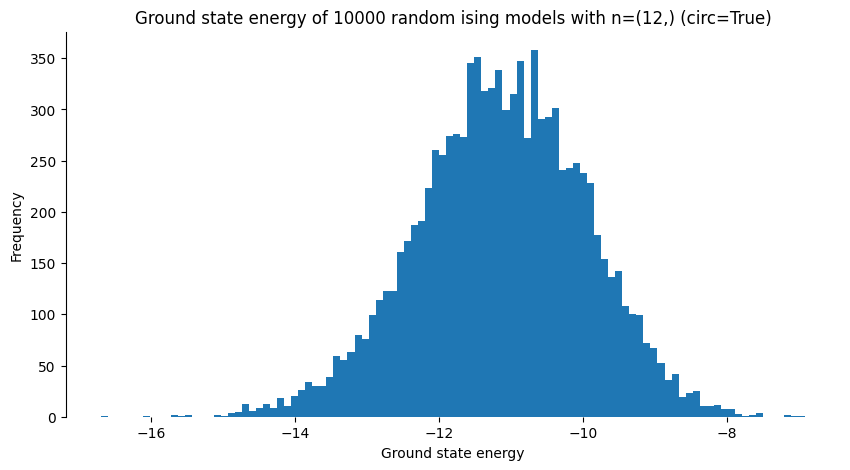

In [10]:
clear_output()
n = (12,) # System size
          # Timing for exact diagonlization (on M1 chip):
          # (8,) => 9000/min, (10,) => 3000/min, (12,) => 1000/min, (14,) => 330/min, (16,) => 90/min, (20,) => 4/min
          # (2,3) => 20000/min, (2,4) => 8500/min, (3,3) => 5000/min, (3,4) => 1000/min, (4,4) => 70/min, (4,5) => 4/min
          # (2,2,2) => 8000/min, (2,2,3) => 800/min, (2,3,3) => 20/min
circular = True  # Circular boundary
N = 100   # Number of samples to generate

# Generate
graph = nk.graph.Grid(n, pbc=circular)
data = generate_dataset(random_ising_own(N, graph), data_path=f'data/own_{n}_{circular}')

# Plot
_ = hist([d['y_energy'] for d in data], xlabel="Ground state energy", title=f"Ground state energy of {len(data)} random ising models with n={n} (circ={circular})")

In [11]:
sys.exit() # here to prevent the notebook from running further and destroying the timings and plots when running all cells

SystemExit: 

In [ ]:
from pennylane import pauli_decompose

# Get a hamiltonian
H = random_ising_own(1, graph=nk.graph.Grid((2,3), pbc=True))[0][0]
# Diagonalize
ge, gs = diagonalize(H)
# Calculate RDMs
node_rdms, edge_rdms = calculate_rdms(gs)
# Pauli decomposition
pauli_decompose(edge_rdms[0])

  (-0.19835015667019273) [I0 X1]
+ (-0.1918411420896014) [Z0 X1]
+ (-0.05733307069643601) [X0 I1]
+ (-0.02708361764855815) [X0 Z1]
+ (-0.00984252771033757) [Y0 Y1]
+ (0.05116831156063491) [X0 X1]
+ (0.14841032028563939) [Z0 Z1]
+ (0.1505894596313756) [I0 Z1]
+ (0.2430813217750133) [Z0 I1]
+ (0.25) [I0 I1]


In [ ]:
# Full procedure for generating the dataset for one hamiltonian
%timeit diagonalize(random_ising_nk(1, nk.graph.Grid((12,), pbc=False))[0][0].to_sparse())
%timeit diagonalize(parse_hamiltonian(random_ising_own(1, nk.graph.Grid((12,), pbc=False))[0][0], sparse=True))

45.4 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
53.8 ms ± 9.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
graph = nk.graph.Grid((8,), pbc=False)

print(f"Abstract Hamiltonian object ({graph.n_nodes} qubits)")
%timeit random_ising_nk(1, graph)
%timeit random_ising_own(1, graph)

print(f"Sparse Hamiltonian matrix ({graph.n_nodes} qubits)")
%timeit random_ising_nk(1, graph)[0][0].to_sparse()
%timeit parse_hamiltonian(random_ising_own(1, graph)[0][0], sparse=True)

H1 = random_ising_nk(1, graph)[0][0].to_sparse()
H2 = parse_hamiltonian(random_ising_own(1, graph)[0][0], sparse=True)

print(f"Diagonalizing the Hamiltonian ({graph.n_nodes} qubits)")
%timeit diagonalize(H1)
%timeit diagonalize(H2)

graph = nk.graph.Grid((12,), pbc=False)

print(f"Abstract Hamiltonian object ({graph.n_nodes} qubits)")
%timeit random_ising_nk(1, graph)
%timeit random_ising_own(1, graph)

print(f"Sparse Hamiltonian matrix ({graph.n_nodes} qubits)")
%timeit random_ising_nk(1, graph)[0][0].to_sparse()
%timeit parse_hamiltonian(random_ising_own(1, graph)[0][0], sparse=True)

H1 = random_ising_nk(1, graph)[0][0].to_sparse()
H2 = parse_hamiltonian(random_ising_own(1, graph)[0][0], sparse=True)

print(f"Diagonalizing the Hamiltonian ({graph.n_nodes} qubits)")
%timeit diagonalize(H1)
%timeit diagonalize(H2)

Abstract Hamiltonian object (8 qubits)
50.8 µs ± 872 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
64.1 µs ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Sparse Hamiltonian matrix (8 qubits)
188 µs ± 3.86 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
5.29 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Diagonalizing the Hamiltonian (8 qubits)
1.15 ms ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1 ms ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Abstract Hamiltonian object (12 qubits)
58.1 µs ± 538 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
81.2 µs ± 986 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Sparse Hamiltonian matrix (12 qubits)
2.89 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.5 ms ± 458 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Diagonalizing the Hamiltonian (12 qubits)
48.4 ms ± 14.6 ms per loop (mean ±

In [ ]:
graph = nk.graph.Grid((8,), pbc=False)
# constructing the abstract representations of the hamiltonians
print(f"Abstract representations ({graph.n_nodes} qubits)")
%timeit len(list(random_ising_nk(N=100, graph=graph)))
%timeit len(list(random_ising_own(N=100, graph=graph)))
# creating the actual matrices
print(f"Matrices ({graph.n_nodes} qubits)")
%timeit len(list(h.to_sparse() for h, _, _ in random_ising_nk(N=100, graph=graph)))
%timeit len(list(parse_hamiltonian(h, sparse=True) for h, _, _ in random_ising_own(N=100, graph=graph)))

graph = nk.graph.Grid((12,), pbc=False)
# constructing the abstract representations of the hamiltonians
print(f"Abstract representations ({graph.n_nodes} qubits)")
%timeit len(list(random_ising_nk(N=100, graph=graph)))
%timeit len(list(random_ising_own(N=100, graph=graph)))
# creating the actual matrices
print(f"Matrices ({graph.n_nodes} qubits)")
%timeit len(list(h.to_sparse() for h, _, _ in random_ising_nk(N=100, graph=graph)))
%timeit len(list(parse_hamiltonian(h, sparse=True) for h, _, _ in random_ising_own(N=100, graph=graph)))

Abstract representations (8 qubits)
1.75 ms ± 24.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
3.63 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Matrices (8 qubits)
12.9 ms ± 299 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
519 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Abstract representations (12 qubits)
1.9 ms ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.35 ms ± 35.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Matrices (12 qubits)
279 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.25 s ± 15.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


2 96 96 B
3 256 256 B
4 640 640 B
5 1536 1.5 KB
6 3584 3.5 KB
7 8192 8.0 KB
8 18432 18 KB
9 40960 40 KB
10 90112 88 KB
11 196608 192 KB
12 425984 416 KB
13 917504 896 KB
14 1966080 1.9 MB
15 4194304 4.0 MB
16 8912896 8.5 MB
17 18874368 18 MB
18 39845888 38 MB
19 83886080 80 MB
20 176160768 168 MB
21 369098752 352 MB
22 771751936 736 MB
23 1610612736 1.5 GB
24 3355443200 3.1 GB


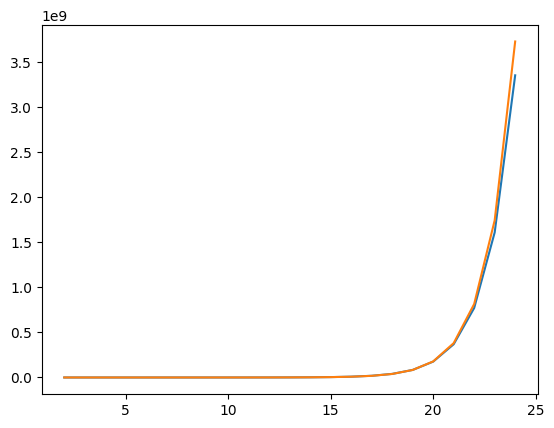

In [ ]:
# Memory usage for sparse hamiltonians
ns = np.arange(2, 25)
nbytess = []
for n in ns:
    # netket version of the Ising model
    nbytes = nk.operator.Ising(
        hilbert=nk.hilbert.Spin(s=0.5, N=int(n)),
        graph=nk.graph.Grid((n,), pbc=False),
        J=1.2, h=2.2
    ).to_sparse().data.nbytes
    nbytess.append(nbytes)
    print(n, nbytes, duh(nbytes))

plt.plot(ns, nbytess)
plt.plot(ns, np.exp(0.76*ns+3.8)) # rough fit


## Mean field ansatz

In [ ]:
import jax.numpy as jnp
import flax.linen as nn
import json

def save_data(specifier, cb=None):
    path = f"data/data_{specifier}.json"
    def _save(arg):
        if cb is not None:
            key, value = cb(arg)
        else:
            key, value = arg
        # append to json dict
        if os.path.exists(path):
            with open(path, "r") as f:
                data = json.load(f)
        else:
            data = {}
        data[key] = value
        with open(path, "w") as f:
            json.dump(data, f, indent=2)
    return _save

In [ ]:
class MF(nn.Module):

    @nn.compact
    def __call__(self, x):
        """
        Input: x.shape = (n_samples, L)
        Output: log_psi.shape = (n_samples,)
        """
        lam = self.param(
            "lambda", nn.initializers.normal(), (1,), float
        )
        p = nn.log_sigmoid(lam*x)
        return 0.5 * jnp.sum(p, axis=-1)
    
def mean_field(hamiltonian, n_samples=1000, n_iter=300, logfile='test', show_progress=False):
    vstate = nk.vqs.MCState(
        sampler=nk.sampler.MetropolisLocal(hamiltonian.hilbert),
        model=MF(),
        n_samples=n_samples,
    )
    optimizer = nk.optimizer.Sgd(learning_rate=0.05)
    gs = nk.driver.VMC(hamiltonian, optimizer, variational_state=vstate)
    gs.run(n_iter=n_iter, out=logfile, show_progress=show_progress)
    energy = vstate.expect(hamiltonian)
    # Check if converged
    if np.abs(energy.R_hat - 1) > 0.1:
        print('Not converged!', energy)
        return str(hamiltonian), np.nan

    return str(hamiltonian), float(energy.mean)

In [ ]:
clear_output()
def plot_json(filename, y, x, exact_energy):
    import json
    with open(filename) as f:
        data = json.load(f)
    data = data["Energy"]
    plt.plot(data[x], data[y])
    plt.axhline(exact_energy, color='r', linestyle='--')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

hamiltonian = random_ising_nk(1, nk.graph.Grid((12,)))[0][0]
print(hamiltonian)
mean_field(hamiltonian, n_samples=1000, n_iter=1000, logfile='test', show_progress=True)
# Also calculate exact energy
exact_energy = sp.linalg.eigsh(hamiltonian.to_sparse().astype(complex), k=1, which='SA')[0][0]
# Read JSON from "test.log" and plot "Energy.mean" against "Energy.iters"
plot_json('test.log', 'Mean', 'iters', exact_energy)

`n_iter == 300` seems like a good choice

## VMC (Jastrow)

In [ ]:
class Jastrow(nn.Module):

    @nn.compact
    def __call__(self, x):
        """
        Input: x.shape = (n_samples, L)
        Output: log_psi.shape = (n_samples,)
        """
        lam1 = self.param(
            "lambda1", nn.initializers.normal(), (1,), float
        )
        lam2 = self.param(
            "lambda2", nn.initializers.normal(), (1,), float
        )
        # compute the nearest-neighbor correlations
        corr1=x*jnp.roll(x,-1,axis=-1)
        corr2=x*jnp.roll(x,-2,axis=-1)

        # sum the output
        return jnp.sum(lam1*corr1+lam2*corr2,axis=-1)

def jastrow(hamiltonian, n_samples=1000, n_iter=30, logfile='test', show_progress=False):
    vstate = nk.vqs.MCState(
        sampler=nk.sampler.MetropolisLocal(hamiltonian.hilbert),
        model=Jastrow(),
        n_samples=n_samples,
    )
    optimizer = nk.optimizer.Sgd(learning_rate=0.05)
    gs = nk.driver.VMC(hamiltonian, optimizer, variational_state=vstate)
    gs.run(n_iter=n_iter, out=logfile, show_progress=show_progress)
    energy = vstate.expect(hamiltonian)
    # Check if converged
    if np.abs(energy.R_hat - 1) > 0.1:
        print('Not converged!', energy)
        return str(hamiltonian), np.nan

    return str(hamiltonian), float(energy.mean)

In [ ]:
clear_output()
def plot_json(filename, y, x, exact_energy):
    import json
    with open(filename) as f:
        data = json.load(f)
    data = data["Energy"]
    plt.plot(data[x], data[y])
    plt.axhline(exact_energy, color='r', linestyle='--')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

hamiltonian = random_ising_nk(1, nk.graph.Grid((12,)))[0][0]
print(hamiltonian)
jastrow(hamiltonian, n_samples=1000, n_iter=300, logfile='test', show_progress=True)
# Also calculate exact energy
exact_energy = sp.linalg.eigsh(hamiltonian.to_sparse().astype(complex), k=1, which='SA')[0][0]
# Read JSON from "test.log" and plot "Energy.mean" against "Energy.iters"
plot_json('test.log', 'Mean', 'iters', exact_energy)

If it converges, it usually takes `10-20` iterations.

## Grand comparison

In [ ]:
exact_energies = {}
mean_field_energies = {}
jastrow_energies = {}

In [ ]:
clear_output()

N = 1000
L = 12
name = "12nk"
hamiltonians_test = random_ising_nk(N, graph=nk.graph.Grid((L,)))

if L <= 23: # Max size with 16GB RAM
    exact_energies[name] = mapp(diagonalize, hamiltonians_test)
    scatter1d([e for e,s in exact_energies[name]], title='Exact ground state energies')

mean_field_energies[name] = mapp(mean_field, hamiltonians_test[::10], cb=save_data(f'mf_{L}'))
scatter1d([e for _,e in mean_field_energies[name]], title='Mean field ground state energies')

jastrow_energies[name] = mapp(jastrow, hamiltonians_test, cb=save_data(f'jastrow_{L}'))
scatter1d([e for _,e in jastrow_energies[name]], title='Jastrow ground state energies')

In [ ]:
sys.exit()

Below this are some generated figures that need quite some time to generate so I didn't want to remove them.

In [ ]:
clear_output()

N = 20000
L = 12
name = "12nk"
hamiltonians_test = random_ising_nk(N, graph=graph=nk.graph.Grid((L,)))

if L <= 23: # Max size with 16GB RAM
    exact_energies[name] = mapp(diagonalize, hamiltonians_test, cb=save_data(f'nk_{L}'))
    hist([e for e,s in exact_energies[name]], title='Exact ground state energies')

In [ ]:
clear_output()

N = 20000
n = (2,3)
name = "6is"
hamiltonians_test = random_ising_own(N, graph=nk.graph.Grid(n))

if np.prod(n) <= 23: # Max size with 16GB RAM
    exact_energies[name] = mapp(diagonalize, hamiltonians_test) # , cb=save_data(f'{n}')
    hist([e for e,s in exact_energies[name]], title='Exact ground state energies')

In [ ]:
clear_output()

N = 200
L = 30
name = "30nk"
hamiltonians_test = random_ising_nk(N, graph=nk.graph.Grid((L,)))

jastrow_energies[name] = mapp(jastrow, hamiltonians_test, cb=save_data(f'jastrow_{L}'))
hist([e for e,s in jastrow_energies[name]], title='Jastrow ground state energies')

In [ ]:
clear_output()

N = 2000
L = 20
name = f"{L}nk"
hamiltonians_test = random_ising_nk(N, graph=nk.graph.Grid((L,)))

exact_energies[name] = mapp(diagonalize, hamiltonians_test, cb=save_data(f'nk_{L}'))
hist([e for e,s in exact_energies[name]], title='Exact ground state energies')